In [9]:
#Run This First (don't edit)

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import gc

# Project import
import artpop
from astropy.visualization import make_lupton_rgb

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(122)

#Initialize variables to deletion step doesn't crash later
#Important to ensure memory doesn't get too large!
src_tot = None
src_disk = None
src_bulge = None
radius = None
radius_disk = None
radius_bulge = None
order_r = None
obs_g = None
obs_r = None
obs_i = None
rgb = None


plt.rcParams['figure.figsize'] = (12, 9) #set figure size

# Solar magnitudes to re-normalize luminosity later
mag_sun = {'LSST_u': 6.27, 'LSST_g': 5.06, 'LSST_r': 4.64, 
           'LSST_i': 4.52, 'LSST_z': 4.51, 'LSST_y': 4.50}

In [10]:
#Dont change anything here or you risk breaking things!

dist = 5 * u.Mpc
pixscale = 1.0
image_size=10 *u.kpc
num_stars_tot = 3e6

pix_scale_rad = pixscale/206264.8
image_size_rad = image_size.to(u.Mpc)/dist
xy_dim = np.int64(image_size_rad/pix_scale_rad)
if xy_dim%2==0: xy_dim+=1

psf = artpop.moffat_psf(fwhm=0.7*u.arcsec)
exp_time = 600*u.min

imager = artpop.ArtImager(
    phot_system = 'LSST', # photometric system
    diameter = 6.4 * u.m, # effective aperture diameter
    read_noise = 4,       # read noise in electrons
    random_state = rng    # random state for reproducibility
)

<h3> Creating a Fake Galaxy of Stars </h3>

Define two stellar populations based on age, metalicity and spatial distribution (dictated by n and R_eff)

In [11]:
#Inputs for Galaxy Properties - Modify these and then run the rest of the cells!

Disk_Properties = {
    'R_eff': 2 * u.kpc,  # effective radius in kpc
    'n': 1,              # Sersic Index
    'feh': 0,         # metalicity of stars
    'log age': 8        #Age of stars
}

Bulge_Properties = {
    'R_eff': 1 * u.kpc,  # effective radius in kpc
    'n': 4,              # Sersic Index
    'feh': 0,         # metalicity of stars
    'log age': 10        #Age of stars
}

#Bulge-to-total (B/T) ratio
Mbulge_Mtot_Ratio = 0.75

###############################

##Don't Edit Below this line!##

###############################

#Delete your data to free up memory before you try new things!
del(src_tot, src_disk, src_bulge, radius, obs_g, obs_r, obs_i, rgb, radius_disk, radius_bulge, order_r)
gc.collect()


#Create the disk
src_disk = artpop.MISTSersicSSP(
    log_age = Disk_Properties['log age'],# log of age in years
    feh = Disk_Properties['feh'],           # metallicity [Fe/H]
    r_eff = Disk_Properties['R_eff'],   # effective radius
    n = Disk_Properties['n'],              # Sersic index
    theta = 0 * u.deg,   # position angle
    ellip = 0,          # ellipticity
    num_stars = np.int64((1-Mbulge_Mtot_Ratio)*num_stars_tot),      # number of stars
    phot_system = 'LSST', # photometric system
    distance = dist, # distance to system
    xy_dim = xy_dim,         # image dimension
    pixel_scale = pixscale,    # pixel scale in arcsec / pixel
    random_state = rng    # random state for reproducibility
)

#Create the bulge
src_bulge = artpop.MISTSersicSSP(
    log_age = Bulge_Properties['log age'],         # log of age in years
    feh = Bulge_Properties['feh'],           # metallicity [Fe/H]
    r_eff = Bulge_Properties['R_eff'],   # effective radius
    n = Bulge_Properties['n'],              # Sersic index
    theta = 0 * u.deg,   # position angle
    ellip = 0.,          # ellipticity
    num_stars = np.int64(Mbulge_Mtot_Ratio * num_stars_tot),      # number of stars
    phot_system = 'LSST', # photometric system
    distance = dist, # distance to system
    xy_dim = xy_dim,         # image dimension
    pixel_scale = pixscale,    # pixel scale in arcsec / pixel
    random_state = rng    # random state for reproducibility
)

<h3> Looking at your galaxy </h3>

Generate a mock image of the galaxy

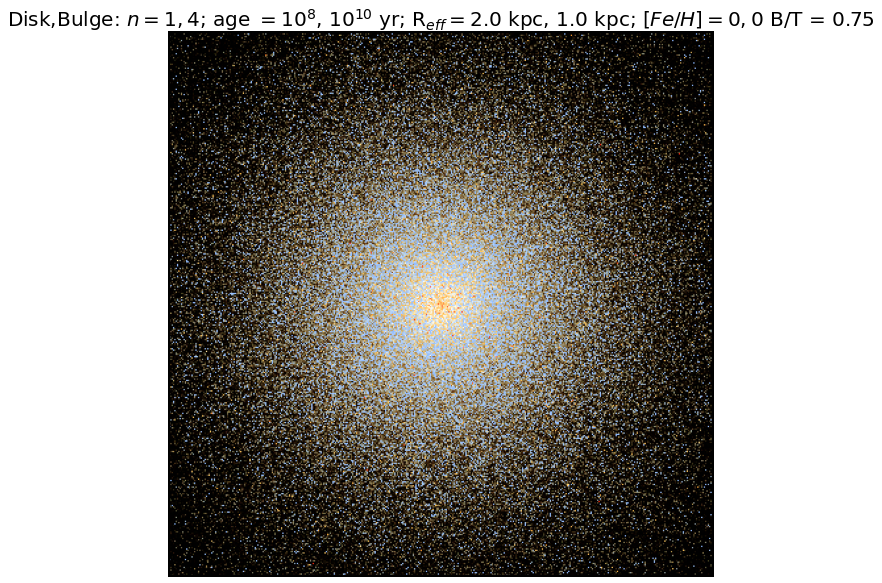

In [12]:
#Create a mock observations

obs_g = imager.observe(src_disk+src_bulge, 'LSST_g', exp_time, zpt=32, sky_sb=None, psf=None)
obs_r = imager.observe(src_disk+src_bulge, 'LSST_r', exp_time, zpt=32, sky_sb=None, psf=None)
obs_i = imager.observe(src_disk+src_bulge, 'LSST_i', exp_time, zpt=32, sky_sb=None, psf=None)

rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.4)

artpop.show_image(rgb);
plt.title('Disk,Bulge: $n= '+str(Disk_Properties['n'])+', '+str(Bulge_Properties['n'])+
          '$; age $= 10^{'+str(Disk_Properties['log age'])+'}$, $10^{'+str(Bulge_Properties['log age'])+'}$ yr; R$_{eff} = $'+
         str(Disk_Properties['R_eff'])+', '+str(Bulge_Properties['R_eff'])+'; $[Fe/H] = '+
          str(Disk_Properties['feh'])+', '+str(Bulge_Properties['feh'])+'$ B/T = '+str(Mbulge_Mtot_Ratio), fontsize=20)

#SAVE THE IMAGE (EDIT THE NAME)
#WARNING! You need to change the name if you don't want to overwrite a previous image!
#Please keep '.pdf' in the name
plt.savefig('GalaxyImage.pdf')


<h3> Examining the Properties of your Galaxy </h3>

<h4> Total Colors </h4>

Calculate the total color of the galaxy

In [13]:
#Combine both the disk and bulge components into one
src_tot = src_disk+src_bulge

#convert to absolute magnitudes using the distance modulus 
# (the same for each component since the galaxy is at a single distance)

# Calculate the total fluxes from the absolute magnitudes

total_flux_i = (10**(-0.4*(src_tot.mags['LSST_i'] - src_disk.sp.dist_mod))).sum()
total_flux_r = (10**(-0.4*(src_tot.mags['LSST_r'] - src_disk.sp.dist_mod))).sum()
total_flux_g = (10**(-0.4*(src_tot.mags['LSST_g'] - src_disk.sp.dist_mod))).sum()
total_flux_u = (10**(-0.4*(src_tot.mags['LSST_u'] - src_disk.sp.dist_mod))).sum()
                
#Define the total magnitude from the total flux and calculate colors

tot_mag_i = -2.5*np.log10(total_flux_i)
tot_mag_r = -2.5*np.log10(total_flux_r)
tot_mag_g = -2.5*np.log10(total_flux_g)
tot_mag_u = -2.5*np.log10(total_flux_u)

print('u-r:', tot_mag_u-tot_mag_r)
print('g-i:', tot_mag_g-tot_mag_i)


u-r: 0.6645073696619033
g-i: 0.1444288781452574


<h4> Half-light Radius </h4>

Here we calculate the radius which encloses half of the total light of the galaxy for different photometric bands.

In [14]:
#calculate the physical radial distance of each star
radius = np.array(np.sqrt((src_tot.x-xy_dim/2)**2+(src_tot.y-xy_dim/2)**2)*pix_scale_rad*dist.to(u.kpc))
radius_disk = np.array(np.sqrt((src_disk.x-xy_dim/2)**2+(src_disk.y-xy_dim/2)**2)*pix_scale_rad*dist.to(u.kpc))
radius_bulge = np.array(np.sqrt((src_bulge.x-xy_dim/2)**2+(src_bulge.y-xy_dim/2)**2)*pix_scale_rad*dist.to(u.kpc))

# Order each component (total, disk, bulge) by radius
order_r = np.argsort(radius)

#Cumulative sum of total star population (disk + bulge)
total_flux_i_rad = np.cumsum(10**(-0.4*src_tot.mags['LSST_i'][order_r]))
total_flux_r_rad = np.cumsum(10**(-0.4*src_tot.mags['LSST_r'][order_r]))
total_flux_g_rad = np.cumsum(10**(-0.4*src_tot.mags['LSST_g'][order_r]))
total_flux_u_rad = np.cumsum(10**(-0.4*src_tot.mags['LSST_u'][order_r]))

#Find half-light radius
r_half_i = radius[order_r[np.argmin(np.abs(total_flux_i_rad/total_flux_i-0.5))]]
r_half_r = radius[order_r[np.argmin(np.abs(total_flux_r_rad/total_flux_r-0.5))]]
r_half_g = radius[order_r[np.argmin(np.abs(total_flux_g_rad/total_flux_g-0.5))]]
r_half_u = radius[order_r[np.argmin(np.abs(total_flux_u_rad/total_flux_u-0.5))]]


print("rhalf, i:", r_half_i)
print("rhalf, r:", r_half_r)
print("rhalf, g:", r_half_g)
print("rhalf, u:", r_half_u)



rhalf, i: 7.06201087114455
rhalf, r: 7.06201087114455
rhalf, g: 7.06201087114455
rhalf, u: 7.044932726190127


<h4> Surface Brightness Profile </h4>

Below we calculate surface brightness (Luminosity per Area) as a function of radius for the total (solid lines) light as well as the individual components (Bulge - dashed, Disk - dotted). We do this for both u and i-bands.

/var/folders/h4/m3h7js2x5l9cngt1l3x74q740000gn/T/ipykernel_91213/3003986457.py:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins[:-1],lum_tot_i/da, color='C0',label='total i-band',lw=3)
/var/folders/h4/m3h7js2x5l9cngt1l3x74q740000gn/T/ipykernel_91213/3003986457.py:25: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins[:-1],lum_bulge_i/da, color='C0',ls='--',label='bulge',lw=3)
/var/folders/h4/m3h7js2x5l9cngt1l3x74q740000gn/T/ipykernel_91213/3003986457.py:26: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins[:-1],lum_disk_i/da, color='C0',ls=':', label='disk',lw=3)
/var/folders/h4/m3h7js2x5l9cngt1l3x74q740000gn/T/ipykernel_91213/3003986457.py:40: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bins[:-1],lum_tot_u/da, color='C1',label='total u-band',lw=3)
/var/folders/h4/m3h7js2x5l9cngt1l3x74q740000gn/T/ipykernel_91213/3003986457.py:41: RuntimeWarning: divide by zero encountered in true_divide

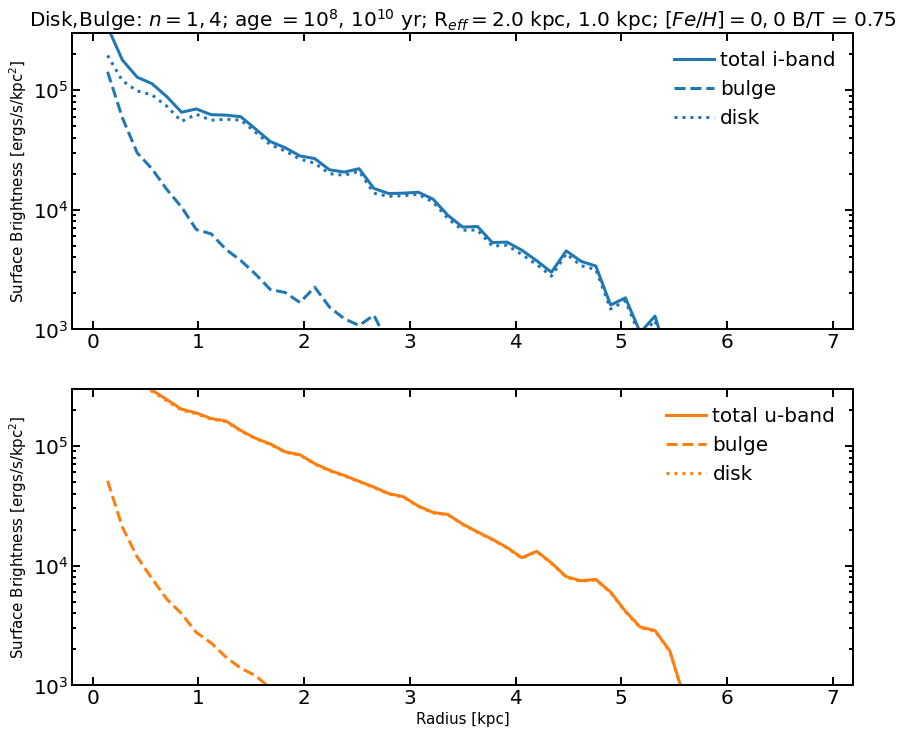

In [15]:
#Calculate total luminosities in radial bins

lum_tot_i, bins = np.histogram(np.array(radius), range=[0,7],bins=50, 
         weights=10**(-0.4*(src_tot.mags['LSST_i'] - src_disk.sp.dist_mod-mag_sun['LSST_i'])))
lum_bulge_i, bins = np.histogram(np.array(radius_bulge), range=[0,7],bins=50, 
         weights=10**(-0.4*(src_bulge.mags['LSST_i'] - src_bulge.sp.dist_mod-mag_sun['LSST_i'])))
lum_disk_i, bins = np.histogram(np.array(radius_disk), range=[0,7],bins=50, 
         weights=10**(-0.4*(src_disk.mags['LSST_i'] - src_disk.sp.dist_mod-mag_sun['LSST_i'])))

lum_tot_u, bins = np.histogram(np.array(radius), range=[0,7],bins=50, 
         weights=10**(-0.4*(src_tot.mags['LSST_u'] - src_disk.sp.dist_mod-mag_sun['LSST_u'])))
lum_bulge_u, bins = np.histogram(np.array(radius_bulge), range=[0,7],bins=50, 
         weights=10**(-0.4*(src_bulge.mags['LSST_u'] - src_bulge.sp.dist_mod-mag_sun['LSST_u'])))
lum_disk_u, bins = np.histogram(np.array(radius_disk), range=[0,7],bins=50, 
         weights=10**(-0.4*(src_disk.mags['LSST_u'] - src_disk.sp.dist_mod-mag_sun['LSST_u'])))

#Calculate area of each bin so that we can convert to a surface brightness
dr = bins[1:]-bins[:-1]
da = 4*np.pi*bins[:-1]*dr

plt.rcParams['figure.figsize'] = (14, 12)
plt.subplot(211)

plt.plot(bins[:-1],lum_tot_i/da, color='C0',label='total i-band',lw=3)
plt.plot(bins[:-1],lum_bulge_i/da, color='C0',ls='--',label='bulge',lw=3)
plt.plot(bins[:-1],lum_disk_i/da, color='C0',ls=':', label='disk',lw=3)
plt.legend(fontsize=20)
plt.yscale('log')
plt.ylim(1e3,3e5)
plt.ylabel('Surface Brightness [ergs/s/kpc$^2$]', fontsize=15)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Disk,Bulge: $n= '+str(Disk_Properties['n'])+', '+str(Bulge_Properties['n'])+
          '$; age $= 10^{'+str(Disk_Properties['log age'])+'}$, $10^{'+str(Bulge_Properties['log age'])+'}$ yr; R$_{eff} = $'+
         str(Disk_Properties['R_eff'])+', '+str(Bulge_Properties['R_eff'])+'; $[Fe/H] = '+
          str(Disk_Properties['feh'])+', '+str(Bulge_Properties['feh'])+'$ B/T = '+str(Mbulge_Mtot_Ratio), fontsize=20)

plt.subplot(212)

plt.plot(bins[:-1],lum_tot_u/da, color='C1',label='total u-band',lw=3)
plt.plot(bins[:-1],lum_bulge_u/da, color='C1',ls='--',label='bulge',lw=3)
plt.plot(bins[:-1],lum_disk_u/da, color='C1',ls=':',label='disk',lw=3)
plt.yscale('log')
plt.ylim(1e3,3e5)
plt.xlabel('Radius [kpc]', fontsize=15)
plt.ylabel('Surface Brightness [ergs/s/kpc$^2$]', fontsize=15)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.legend(fontsize=20)

#SAVE THE IMAGE (EDIT THE NAME)
#WARNING! You need to change the name if you don't want to overwrite a previous image!
#Please keep '.pdf' in the name
plt.savefig('SurfaceBrightnessProfiles.pdf') 
         

<h4> Colors At Different Radii </h4>

Here we calculate two different photometric colors: u - r and g - i for our mock galaxy as a function of radius. 

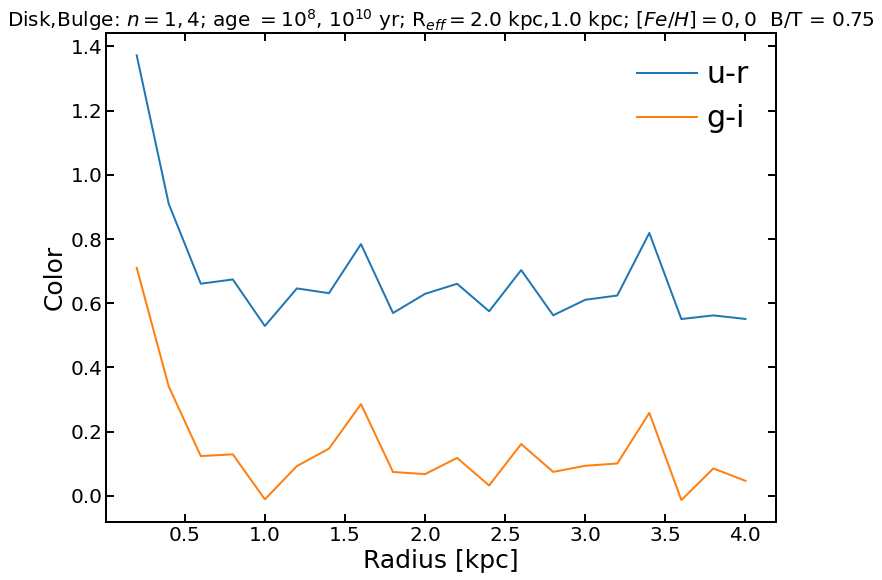

In [16]:
r = np.array(radius[order_r])
rrange = [0,np.max(np.array([Disk_Properties['R_eff']/u.kpc,Bulge_Properties['R_eff']/u.kpc]))*2]
lum_u, bins = np.histogram(r,range=rrange,bins=20,
                         weights=10**(-0.4*(src_tot.mags['LSST_u'][order_r])),
                        )
lum_g, bins = np.histogram(r,range=rrange,bins=20,
                         weights=10**(-0.4*(src_tot.mags['LSST_g'][order_r])),
                        )
lum_r, bins = np.histogram(r,range=rrange,bins=20,
                         weights=10**(-0.4*(src_tot.mags['LSST_r'][order_r])),
                        )
lum_i, bins = np.histogram(r,range=rrange,bins=20,
                         weights=10**(-0.4*(src_tot.mags['LSST_i'][order_r])),
                        )

mag_u_r = -2.5*np.log10(lum_u)
mag_g_r = -2.5*np.log10(lum_g)
mag_r_r = -2.5*np.log10(lum_r)
mag_i_r = -2.5*np.log10(lum_i)
plt.rcParams['figure.figsize'] = (12, 9)
plt.plot(bins[1:],mag_u_r-mag_r_r,lw=2,label='u-r')
plt.plot(bins[1:],mag_g_r-mag_i_r,lw=2, label='g-i')
plt.legend(fontsize=30)
plt.ylabel('Color', fontsize=25)
plt.xlabel('Radius [kpc]', fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Disk,Bulge: $n= '+str(Disk_Properties['n'])+','+str(Bulge_Properties['n'])+
          '$; age $= 10^{'+str(Disk_Properties['log age'])+'}$, $10^{'+str(Bulge_Properties['log age'])+'}$ yr; R$_{eff} = $'+
         str(Disk_Properties['R_eff'])+','+str(Bulge_Properties['R_eff'])+'; $[Fe/H] = '+
          str(Disk_Properties['feh'])+','+str(Bulge_Properties['feh'])+'$  B/T = '+str(Mbulge_Mtot_Ratio), fontsize=20)

#SAVE THE IMAGE (EDIT THE NAME)
#WARNING! You need to change the name if you don't want to overwrite a previous image!
#Please keep '.pdf' in the name
plt.savefig('ColorProfile.pdf')
                         